In [1]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np

In [Melbourne Airbnb Price Prediction](https://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26586189.pdf ) they only use text and non-text data that are stored in cleansed_listings_dec18.csv and text data from reviews_dec18.csv.

In [2]:
clean_listings = pd.read_csv(
    '../data/raw/airbnb/cleansed_listings_dec18.csv', low_memory=False)
useless_cols = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_url', 'host_id',
                'host_name', 'host_thumbnail_url', 'host_picture_url', 'country_code', 'country',
                'is_location_exact', 'calendar_updated','cancellation_policy', 'instant_bookable', 
                'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 'license',
                'has_availability', 'zipcode', 'host_has_profile_pic', 'host_identity_verified',
                'state','host_location','street', 'suburb','smart_location', 'require_guest_profile_picture',
                'require_guest_phone_verification']
clean_listings.drop(useless_cols, axis=1, inplace=True)
clean_listings.dropna(axis='columns', thresh=round(0.8*len(clean_listings)), inplace=True)
clean_listings.shape

(22895, 28)

In [3]:
# Drop rows where price is 0 or over 1000
clean_listings = clean_listings[(clean_listings.price>0) & (clean_listings.price<1000)]
clean_listings['#host_verifications'] = clean_listings[['host_verifications']].applymap(lambda x: len(x.split(',')))
clean_listings.drop('host_verifications', axis=1, inplace=True)

# get all unique amenities
amenities = set()
for i in clean_listings['amenities']:
    fts = i[1:-1].split(',')
    for ft in fts:
        amenities.add(re.sub(r'["{}]', '', ft).strip())
amenities.remove('')

def get_amenities(amenity):
    fts = amenity[1:-1].split(',')
    fts = [re.sub(r'["{}]', '', ft).strip() for ft in fts]
    return fts
clean_listings['amenities'] = clean_listings['amenities'].apply(get_amenities)

# Turn amenities into binary features
for amenity in tqdm(amenities):
    clean_listings[amenity] = clean_listings['amenities'].apply(lambda x: 1 if amenity in x else 0)
    
clean_listings.drop('amenities', axis=1, inplace=True)

clean_listings['host_since'] = pd.to_datetime(clean_listings['host_since'])
# Turn host_since into number of days since clean_listings['host_since'].min()
clean_listings['host_since'] = (clean_listings['host_since'] - clean_listings['host_since'].min()).dt.days

 47%|████▋     | 88/187 [00:00<00:00, 106.82it/s]/tmp/ipykernel_14882/407891736.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clean_listings[amenity] = clean_listings['amenities'].apply(lambda x: 1 if amenity in x else 0)
/tmp/ipykernel_14882/407891736.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clean_listings[amenity] = clean_listings['amenities'].apply(lambda x: 1 if amenity in x else 0)
/tmp/ipykernel_14882/407891736.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

## Categorical features

In [4]:
categorical_fts = ['bed_type', 'room_type', 'property_type', 'city']
clean_listings[categorical_fts].nunique()

bed_type          5
room_type         3
property_type    35
city             30
dtype: int64

In [5]:
# Turn categorical features into dummy variables
for col in categorical_fts:
    clean_listings = pd.concat([clean_listings, pd.get_dummies(clean_listings[col], prefix=col)], axis=1)
    clean_listings.drop(col, axis=1, inplace=True)
    
# change host_is_superhost to binary
clean_listings['host_is_superhost'] = clean_listings['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)
clean_listings.dropna(axis='rows', inplace=True)

## Predict using only non-text features

In [6]:
text_features = ['name', 'summary', 'description']

In [7]:
Y = clean_listings['price']
X = clean_listings.drop(text_features+['price'], axis=1)

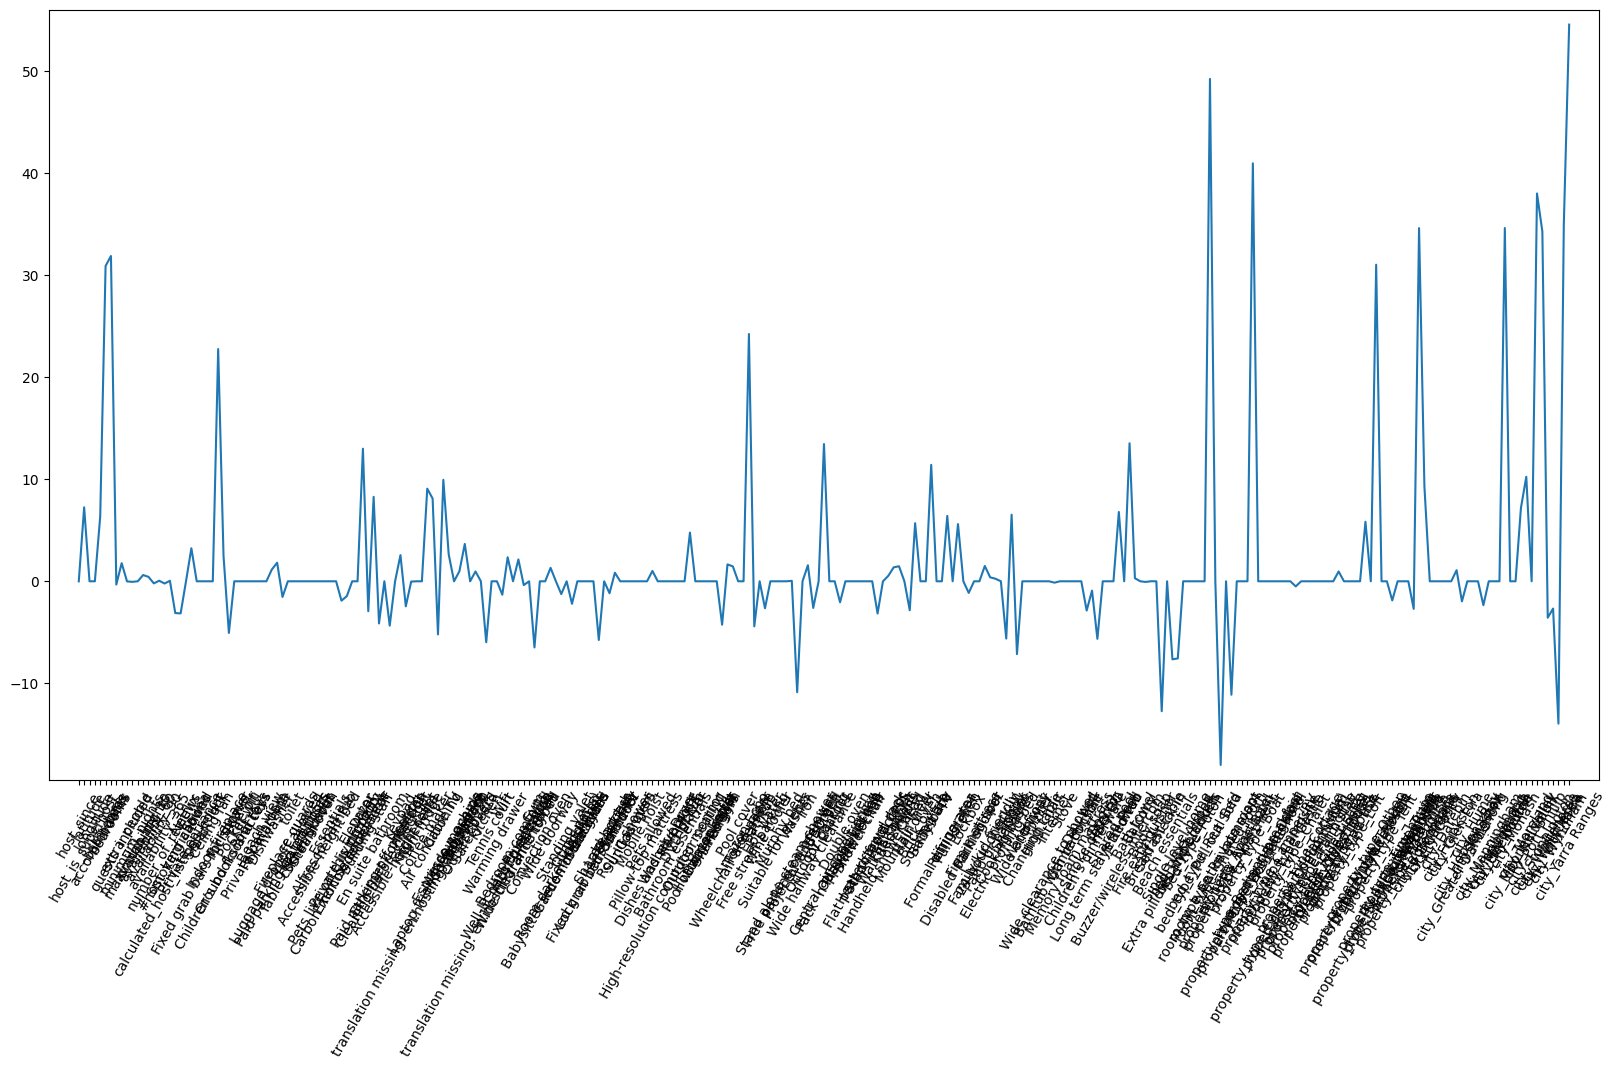

In [8]:
# Perform lasso to select features
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Plot the coefficients
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(range(len(X.columns)), lasso_coef)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.margins(0.02)
plt.show()


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

RMSE:  85.23036991609997
0.46587344526327845


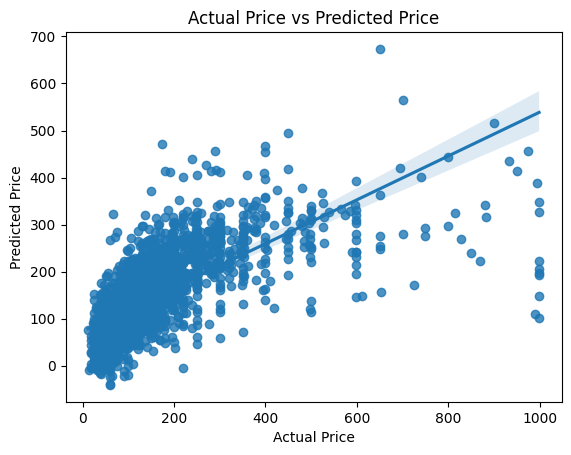

In [10]:

# Select features with non-zero coefficients
selected_fts = X.columns[lasso_coef!=0]

# fit a linear regression model

X_train, X_test, y_train, y_test = train_test_split(X[selected_fts], Y, test_size=0.15, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

# Caluclate the R-squared
print(r2_score(y_test, y_pred))

# Plot y vs y_pred on seaborn

sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()



## Plot without feature selection

RMSE:  85.23036991609997
R^2:  0.46587344526327845


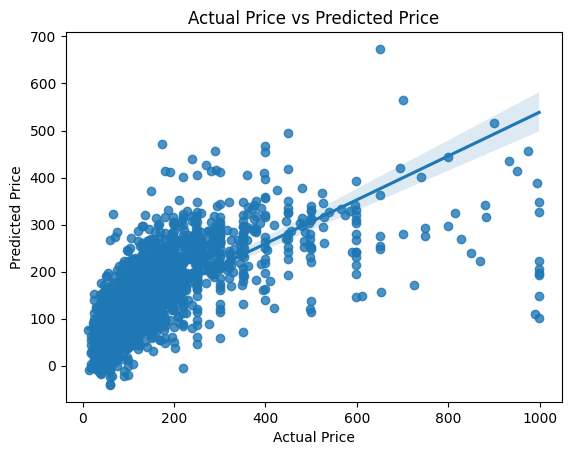

In [11]:
Y = clean_listings['price']
X = clean_listings.drop(text_features+['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X[selected_fts], Y, test_size=0.15, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

# Caluclate the R-squared
print('R^2: ',r2_score(y_test, y_pred))

# Plot y vs y_pred on seaborn

sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()

## xGBoost

In [12]:
# Fit xgboost model
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: ',r2_score(y_test, y_pred))

RMSE:  73.62094973961062
R^2:  0.6014725368500465


## Predict using only text features

# Steps
* model is imported from the transformers lib
* 


In [13]:
clean_listings

,name,summary,description,host_since,host_is_superhost,latitude,longitude,accommodates,bathrooms,bedrooms,...,city_Moonee Valley,city_Moreland,city_Nillumbik,city_Port Phillip,city_Stonnington,city_Whitehorse,city_Whittlesea,city_Wyndham,city_Yarra,city_Yarra Ranges
1,Room in Cool Deco Apartment in Brunswick,A large air conditioned room with queen spring...,A large air conditioned room with queen spring...,195.0,0,-37.766505,144.980736,2,1.0,1.0,...,0,1,0,0,0,0,0,0,0,0
2,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,240.0,1,-37.859755,144.977369,3,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
3,Large private room-close to city,"Comfortable, relaxed house, a home away from ...","Comfortable, relaxed house, a home away from ...",273.0,0,-37.758971,144.989228,1,1.5,1.0,...,0,0,0,0,0,0,0,0,0,0
5,Melbourne - Old Trafford Apartment,Please note: No booking will be accepted with ...,Please note: No booking will be accepted with ...,494.0,1,-38.057254,145.339356,5,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
6,CLOSE TO CITY & MELBOURNE AIRPORT,Easy to travel from and to the Airport; quiet ...,Easy to travel from and to the Airport; quiet ...,509.0,0,-37.697294,145.000816,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22890,lovely home,"near city, near tram station","near city, near tram station",3562.0,0,-37.802415,144.962967,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
22891,Melton South Getaway,"Close to: Melton Rail, Coles, Coffee Lounge an...","Close to: Melton Rail, Coles, Coffee Lounge an...",3116.0,0,-37.705095,144.574474,4,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
22892,"Glen Waverley(close to train, post, stores)近地铁...","Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...","Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",2993.0,0,-37.875252,145.162757,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
22893,Crown Jewel in the heart of Melbourne,Immaculately presented and carefully maintaine...,Immaculately presented and carefully maintaine...,2051.0,0,-37.827795,144.954987,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
from datasets import Dataset, DatasetDict
import torch
from transformers import BertTokenizer, BertForSequenceClassification


def combine_text_columns(data):
    # data['input'] = data['name'] + ' ' + data['summary'] + ' ' + data['description']
    data['text'] = data['description']
    return data

df = clean_listings[text_features+['price']][~clean_listings['description'].isnull()]
# Define a regex pattern to match Chinese characters
pattern = re.compile(r'[\u4e00-\u9fff]')
# Filter out rows where 'description' contains Chinese characters
df = df[~df['description'].str.contains(pattern, na=False)]
Y = df['price']
df = df.drop('price', axis=1)

X_text = Dataset.from_pandas(df).map(combine_text_columns)
X_text = X_text.remove_columns(['name', 'summary', 'description'])
# X_text.dropna(axis='rows', inplace=True)


# Rename columns
X_text = X_text.rename_column('__index_level_0__', 'id')
X_text = X_text.add_column('label', Y.astype('float32'))

# Train test split
train_test = X_text.train_test_split(test_size=0.15, shuffle=True, seed=42)
train_validation = train_test['train'].train_test_split(test_size=0.15/0.85, shuffle=True, seed=42)
X_text = DatasetDict({'train': train_validation['train'], 'validation': train_validation['test'], 'test': train_test['test']})

mean_price = np.mean(X_text['train']['label'])
std_price = np.std(X_text['train']['label'])

def normalize_price(example):
    example['scaled_label'] = (example['label'] - mean_price) / std_price
    return example

X_text = X_text.map(normalize_price)

# X_text.save_to_disk('../data/processed/airbnb/summaries')
X_text.push_to_hub('airbnb_summaries')

Pushing split train to the Hub.                                     
Deleting unused files from dataset repository: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]
Pushing split validation to the Hub.
Deleting unused files from dataset repository: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
Pushing split test to the Hub.
Deleting unused files from dataset repository: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


In [17]:
X_text['train']['__index_level_0__']

[18346,
 10450,
 17696,
 16166,
 12684,
 6811,
 15489,
 13048,
 9315,
 13678,
 22626,
 4457,
 14869,
 4799,
 7935,
 8784,
 2430,
 4365,
 21625,
 13449,
 3708,
 3205,
 20373,
 2590,
 12136,
 19311,
 13939,
 21411,
 18462,
 19806,
 1691,
 18338,
 14564,
 887,
 17039,
 5711,
 15501,
 6352,
 14779,
 20856,
 7765,
 13036,
 22062,
 14652,
 19560,
 9989,
 8695,
 5332,
 1900,
 3015,
 3013,
 15204,
 18558,
 4249,
 14977,
 17933,
 20867,
 7777,
 14603,
 4196,
 274,
 398,
 8475,
 18516,
 7594,
 16769,
 9096,
 15490,
 11428,
 12157,
 17071,
 1095,
 12524,
 4423,
 10977,
 11813,
 20444,
 14449,
 13016,
 13719,
 13755,
 10851,
 11379,
 5633,
 3176,
 9661,
 9666,
 5000,
 8617,
 7274,
 12444,
 11908,
 8568,
 5396,
 1276,
 8856,
 4989,
 18036,
 5706,
 8893,
 18235,
 6484,
 21342,
 7617,
 21634,
 15218,
 3954,
 2680,
 20850,
 17120,
 4800,
 8177,
 6341,
 17757,
 2028,
 18124,
 12603,
 21954,
 7422,
 18518,
 8247,
 7946,
 45,
 19898,
 7400,
 15968,
 3879,
 4760,
 19919,
 21774,
 2105,
 6667,
 4100,
 1694

In [15]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1, problem_type='regression')
# model = torch.compile(model) # This line is for PyTorch 2.0

X_text = X_text.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from lion_pytorch import Lion
from transformers import Trainer, TrainingArguments, get_linear_schedule_with_warmup
args = TrainingArguments(
    output_dir="../models/airbnb",  # output directory
    num_train_epochs=3,  # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,  # batch size for evaluation
    remove_unused_columns=False,
)
opt = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = get_linear_schedule_with_warmup(opt, num_warmup_steps=args.warmup_steps, num_training_steps=args.max_steps)
trainer = Trainer(
    optimizers=(opt, None),
    model=model,
    args=args,
    train_dataset=X_text["train"],
    eval_dataset=X_text["test"],
)
trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 15
  Batch size = 16
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


{'eval_loss': 14782.3623046875,
 'eval_runtime': 0.2724,
 'eval_samples_per_second': 55.064,
 'eval_steps_per_second': 3.671}

/tmp/ipykernel_118587/350534415.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y)


<Axes: xlabel='price', ylabel='Density'>

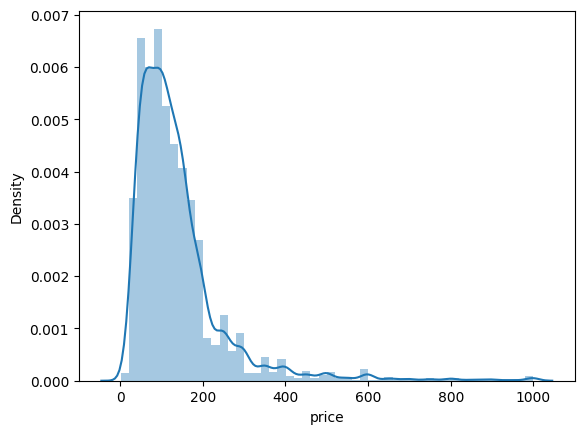

In [ ]:
# sns plot y distribution
sns.distplot(Y)

In [ ]:
X_text["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 69
})

In [ ]:
X_text.save_to_disk('../data/processed/airbnb/summaries')

In [ ]:
from datasets import load_dataset, load_from_disk

ds = load_from_disk('../data/processed/airbnb/summaries')

In [ ]:
ds['train']['labe']

KeyError: "Column labe not in the dataset. Current columns in the dataset: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']"

In [ ]:
np.sqrt(4526)

67.27555276621665

In [ ]:
clean_listings[text_features]['description'].iloc[0]

"A large air conditioned room with queen spring mattress bed in a vintage apartment. Located right outside is a tram to the city just 19 minutes away. This area is known for its arts culture, live music, cafes and international food. The apartment is Deco/Edwardian in style and has polished floorboards and ornate ceilings and wooden blinds. Your room is large sized, has polished floorboards, a Queen sized spring mattress bed and vintage furniture. The rest of the flat also vintage style with 1940's style tiled bathroom with a shower bath, a groovy little kitchen and a deco style lounge room with vintage furniture and bric a brac. The flat is located next to two major public transport routes. Tram 96 is just 30 metres away and takes you south to the city centre in 15-20 minutes or all the way to St Kilda beach in 45 minutes. Bus stops take you east to Bundoora and west to Pacoevale. The Lygon Street tram line that goes past Melbourne University is 10 minutes walk west and Sydney Road an

In [ ]:
clean_listings[text_features]['summary'].iloc[0]

'A large air conditioned room with queen spring mattress bed in a vintage apartment. Located right outside is a tram to the city just 19 minutes away. This area is known for its arts culture, live music, cafes and international food.'

In [ ]:
clean_listings[text_features].iloc[0]

name                    Room in Cool Deco Apartment in Brunswick
summary        A large air conditioned room with queen spring...
description    A large air conditioned room with queen spring...
Name: 1, dtype: object

In [125]:
raw = pd.read_csv(
    '../data/raw/airbnb/cleansed_listings_dec18.csv', low_memory=False)
# drop rows with missing values
raw = raw[~raw['description'].isnull()]

# Define a regex pattern to match Chinese characters
pattern = re.compile(r'[\u4e00-\u9fff]')


# Filter out rows where 'description' contains Chinese characters
raw = raw[~raw['description'].str.contains(pattern, na=False)]

In [160]:
def find_space_in_description(row):
    if row['space'] == 'NaN' or row['description'] == 'NaN':
        return True
    else:
        return str(row['space'])[:50] in str(row['description'])
    

raw['space in description'] = raw.apply(find_space_in_description, axis=1)
raw['description in space'] = raw.apply(lambda row: str(row['description'])[:50] in str(row['space']), axis=1)
raw['space=description'] = raw['space'] == raw['description']
raw['space>description'] = raw['space'].str.len() > raw['description'].str.len()

In [162]:
raw[['space', 'description','neighborhood_overview','notes']][raw['space>description']].to_csv('test')

In [161]:
raw

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,space in description,space=description,space>description,description in space
0,9835,https://www.airbnb.com/rooms/9835,2.018120e+13,12/7/2018,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,NaN,...,f,strict_14_with_grace_period,f,f,1,0.04,True,True,False,True
1,10803,https://www.airbnb.com/rooms/10803,2.018120e+13,12/7/2018,Room in Cool Deco Apartment in Brunswick,A large air conditioned room with queen spring...,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,NaN,...,t,moderate,t,t,1,1.50,True,False,False,False
2,12936,https://www.airbnb.com/rooms/12936,2.018120e+13,12/7/2018,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,FREE WiFi FREE in-building remote controlled g...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,First floor apartment with both lift and stair...,...,f,strict_14_with_grace_period,f,f,17,0.15,True,False,False,False
3,15246,https://www.airbnb.com/rooms/15246,2.018120e+13,12/7/2018,Large private room-close to city,"Comfortable, relaxed house, a home away from ...",The atmosphere is relaxed and easy going. You ...,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...",A simple self service breakfast is available –...,...,f,moderate,f,f,3,0.30,True,False,False,False
4,16760,https://www.airbnb.com/rooms/16760,2.018120e+13,12/7/2018,Melbourne BnB near City & Sports,NaN,We offer comfortable accommodation in Inner Me...,We offer comfortable accommodation in Inner Me...,NaN,NaN,...,f,moderate,f,f,1,0.74,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22889,30592128,https://www.airbnb.com/rooms/30592128,2.018120e+13,12/7/2018,Valuable share room in CBD,This is a idea for short stay backpacker who d...,The price includes the one single mattress in ...,This is a idea for short stay backpacker who d...,NaN,Please keep the place nice any clean as you go,...,f,moderate,f,f,1,NaN,True,False,False,False
22890,30592332,https://www.airbnb.com/rooms/30592332,2.018120e+13,12/7/2018,lovely home,"near city, near tram station",NaN,"near city, near tram station",NaN,NaN,...,t,flexible,f,f,1,NaN,False,False,False,False
22891,30592345,https://www.airbnb.com/rooms/30592345,2.018120e+13,12/7/2018,Melton South Getaway,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,NaN,...,t,flexible,f,f,2,NaN,False,False,False,False
22893,30592590,https://www.airbnb.com/rooms/30592590,2.018120e+13,12/7/2018,Crown Jewel in the heart of Melbourne,Immaculately presented and carefully maintaine...,Security is a focus with intercom-activated en...,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,NaN,...,t,moderate,f,f,17,NaN,True,False,False,False


In [87]:

raw.dropna(subset=['description'], inplace=True)

In [152]:
raw[['space', 'description', 'space in description', 'space=description']][(~raw['space'].isnull()) & (~ raw['space in description']) & (raw['space']!='#NAME?')].to_csv('test')

In [124]:
raw[['space', 'description', 'summary']][~raw['description'].isnull()]

,space,description,summary
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",NaN
1,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,A large air conditioned room with queen spring...
2,FREE WiFi FREE in-building remote controlled g...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...
3,The atmosphere is relaxed and easy going. You ...,"Comfortable, relaxed house, a home away from ...","Comfortable, relaxed house, a home away from ..."
4,We offer comfortable accommodation in Inner Me...,We offer comfortable accommodation in Inner Me...,NaN
...,...,...,...
22890,NaN,"near city, near tram station","near city, near tram station"
22891,NaN,"Close to: Melton Rail, Coles, Coffee Lounge an...","Close to: Melton Rail, Coles, Coffee Lounge an..."
22892,NaN,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...","Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租..."
22893,Security is a focus with intercom-activated en...,Immaculately presented and carefully maintaine...,Immaculately presented and carefully maintaine...


In [154]:

raw

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,space in description,space=description
0,9835,https://www.airbnb.com/rooms/9835,2.018120e+13,12/7/2018,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,NaN,...,f,NaN,f,strict_14_with_grace_period,f,f,1,0.04,True,True
1,10803,https://www.airbnb.com/rooms/10803,2.018120e+13,12/7/2018,Room in Cool Deco Apartment in Brunswick,A large air conditioned room with queen spring...,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,NaN,...,f,NaN,t,moderate,t,t,1,1.50,True,False
2,12936,https://www.airbnb.com/rooms/12936,2.018120e+13,12/7/2018,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,FREE WiFi FREE in-building remote controlled g...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,First floor apartment with both lift and stair...,...,f,NaN,f,strict_14_with_grace_period,f,f,17,0.15,True,False
3,15246,https://www.airbnb.com/rooms/15246,2.018120e+13,12/7/2018,Large private room-close to city,"Comfortable, relaxed house, a home away from ...",The atmosphere is relaxed and easy going. You ...,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...",A simple self service breakfast is available –...,...,f,NaN,f,moderate,f,f,3,0.30,True,False
4,16760,https://www.airbnb.com/rooms/16760,2.018120e+13,12/7/2018,Melbourne BnB near City & Sports,NaN,We offer comfortable accommodation in Inner Me...,We offer comfortable accommodation in Inner Me...,NaN,NaN,...,f,NaN,f,moderate,f,f,1,0.74,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22889,30592128,https://www.airbnb.com/rooms/30592128,2.018120e+13,12/7/2018,Valuable share room in CBD,This is a idea for short stay backpacker who d...,The price includes the one single mattress in ...,This is a idea for short stay backpacker who d...,NaN,Please keep the place nice any clean as you go,...,f,NaN,f,moderate,f,f,1,NaN,True,False
22890,30592332,https://www.airbnb.com/rooms/30592332,2.018120e+13,12/7/2018,lovely home,"near city, near tram station",NaN,"near city, near tram station",NaN,NaN,...,f,NaN,t,flexible,f,f,1,NaN,False,False
22891,30592345,https://www.airbnb.com/rooms/30592345,2.018120e+13,12/7/2018,Melton South Getaway,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,NaN,...,f,NaN,t,flexible,f,f,2,NaN,False,False
22893,30592590,https://www.airbnb.com/rooms/30592590,2.018120e+13,12/7/2018,Crown Jewel in the heart of Melbourne,Immaculately presented and carefully maintaine...,Security is a focus with intercom-activated en...,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,NaN,...,f,NaN,t,moderate,f,f,17,NaN,True,False


## Multimodal

In [54]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch.nn as nn
from datasets import load_dataset

In [40]:
X_train = X[X.index.isin(X_text['train']['id'])]
X_val = X[X.index.isin(X_text['validation']['id'])]
X_test = X[X.index.isin(X_text['test']['id'])]
y_train = Y[Y.index.isin(X_text['train']['id'])]
y_val = Y[Y.index.isin(X_text['validation']['id'])]
y_test = Y[Y.index.isin(X_text['test']['id'])]

In [41]:
tab_model = xgb.XGBRegressor()
tab_model.fit(X_train, y_train)
tab_y_pred = tab_model.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, tab_y_pred)))
print('R^2: ',r2_score(y_test, tab_y_pred))

RMSE:  74.05628150017333
R^2:  0.6082528798824571


In [56]:
model_base = '../models/airbnb/giddy-bush-2/checkpoint-7720'

bert_model  = AutoModelForSequenceClassification.from_pretrained(
        model_base, num_labels=1, problem_type="regression"
    )
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')



# Tokenize the dataset
def encode(examples):
    return {"label": np.array([examples["label"]]),
            **tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)}
dataset = X_text.map(encode,load_from_cache_file=False)
trainer = Trainer(model=bert_model)

In [62]:
tab_val_preds = tab_model.predict(X_val)
# make predictions with bert model
bert_val_preds = trainer.predict(dataset['validation'])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3309
  Batch size = 8
100%|██████████| 414/414 [00:41<00:00, 10.04it/s]


In [74]:
trainer.predict(dataset['train'].select(range(100)))

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 8
  5%|▌         | 102/1930 [01:35<28:30,  1.07it/s] 


PredictionOutput(predictions=array([[131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131.82393],
       [131

In [73]:
# random sample of dataset
sample = dataset['train'].select(range(100))

```python
class TnTEnsembleModel(nn.Module):
    def __init__(self, bert_model, tab_model, text_weight=0.5):
        super().__init__()
        self.bert_model = bert_model
        self.tab_model = tab_model
        self.text_weight = text_weight

    def predict(self, input_ids, attention_mask, token_type_ids, tab_features):
        bert_output = self.bert_model(input_ids, attention_mask, token_type_ids)
        tab_output = self.tab_model(tab_features)
        output = self.text_weight * bert_output + (1 - self.text_weight) * tab_output
        return output
    
model = TnTEnsembleModel(bert_model, tab_model)

tabular_data = torch.tensor(X_test.values, dtype=torch.float32)
text_data = load_dataset('james-burton/airbnb_summaries')
```

In [67]:
bert_val_preds

PredictionOutput(predictions=array([[131.82393],
       [131.82393],
       [131.82393],
       ...,
       [131.82393],
       [131.82393],
       [131.82393]], dtype=float32), label_ids=array([[ 71.],
       [161.],
       [ 82.],
       ...,
       [109.],
       [100.],
       [181.]], dtype=float32), metrics={'test_loss': 13468.2490234375, 'test_runtime': 41.381, 'test_samples_per_second': 79.964, 'test_steps_per_second': 10.005})

In [65]:
from itertools import product

# grid search weights
def grid_search(text_preds, tab_preds, y):
    # define weights to consider
    w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    best_score, best_weight = 0.0, None
    # iterate all possible combinations (cartesian product)
    for weight in w:
        pred = text_preds * weight + tab_preds * (1.0 - weight)
        loss = np.sqrt(mean_squared_error(y, pred))
        print('Weight=%.1f, RMSE=%.3f' % (weight, loss))
        if loss < best_score:
            best_score, best_weight = loss, weight
        

In [75]:
clean_listings = pd.read_csv(
    '../data/raw/airbnb/cleansed_listings_dec18.csv', low_memory=False)

In [76]:
clean_listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,review_scores_location,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,9835,https://www.airbnb.com/rooms/9835,2.018120e+13,12/7/2018,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,NaN,...,9.0,9.0,f,NaN,f,strict_14_with_grace_period,f,f,1,0.04
1,10803,https://www.airbnb.com/rooms/10803,2.018120e+13,12/7/2018,Room in Cool Deco Apartment in Brunswick,A large air conditioned room with queen spring...,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,NaN,...,9.0,9.0,f,NaN,t,moderate,t,t,1,1.50
2,12936,https://www.airbnb.com/rooms/12936,2.018120e+13,12/7/2018,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,FREE WiFi FREE in-building remote controlled g...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,First floor apartment with both lift and stair...,...,9.0,9.0,f,NaN,f,strict_14_with_grace_period,f,f,17,0.15
3,15246,https://www.airbnb.com/rooms/15246,2.018120e+13,12/7/2018,Large private room-close to city,"Comfortable, relaxed house, a home away from ...",The atmosphere is relaxed and easy going. You ...,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...",A simple self service breakfast is available –...,...,9.0,9.0,f,NaN,f,moderate,f,f,3,0.30
4,16760,https://www.airbnb.com/rooms/16760,2.018120e+13,12/7/2018,Melbourne BnB near City & Sports,NaN,We offer comfortable accommodation in Inner Me...,We offer comfortable accommodation in Inner Me...,NaN,NaN,...,10.0,9.0,f,NaN,f,moderate,f,f,1,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22890,30592332,https://www.airbnb.com/rooms/30592332,2.018120e+13,12/7/2018,lovely home,"near city, near tram station",NaN,"near city, near tram station",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,1,NaN
22891,30592345,https://www.airbnb.com/rooms/30592345,2.018120e+13,12/7/2018,Melton South Getaway,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,2,NaN
22892,30592362,https://www.airbnb.com/rooms/30592362,2.018120e+13,12/7/2018,"Glen Waverley(close to train, post, stores)近地铁...","Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,1,NaN
22893,30592590,https://www.airbnb.com/rooms/30592590,2.018120e+13,12/7/2018,Crown Jewel in the heart of Melbourne,Immaculately presented and carefully maintaine...,Security is a focus with intercom-activated en...,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,NaN,...,NaN,NaN,f,NaN,t,moderate,f,f,17,NaN
